In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'train.csv' 
data = pd.read_csv(file_path)

data.head()

,Stock code,Z-SCORE,Share pledge ratio of controlling shareholders,Pledge ratio of limited sale shares,Pledge ratio of unlimited shares,Stock Volatility,P/E ratio,P/B ratio,Stock price rise and fall in the last year,Annual turnover rate,...,Debt financing costs,Enterprise age,Goodwill impairment ratio,Asset quality index,SG&A Expense,Number of key audit matters,Number of research institutions concerned,Number of research reports (+1 LN),Financial cycle m2/gdp,IsDefault
0,X00001,2.420039,0.152395,0.000000,0.126366,49.318786,31.40618754,3.658663,-0.366077,1.420614,...,-0.020707,11.258333,0.000000,1.212208,1.158201,1,3.688879,5.505332,0.028941,0
1,X00002,3.844693,0.608351,0.014874,0.159443,48.390237,30.42292058,5.460896,-0.133857,2.676361,...,0.026496,9.166667,-0.000210,1.058507,1.021779,1,3.496508,5.332719,-0.059096,0
2,X00003,4.975553,0.499388,0.000000,0.153660,46.639579,106.732585,3.636306,-0.304963,5.589544,...,0.018959,10.175000,-0.000052,1.138692,1.260414,2,3.784190,5.318120,-0.067378,0
3,X00004,4.088897,0.000000,0.000000,0.001285,31.025124,12.81982971,3.392250,0.906496,2.538287,...,-0.001030,16.494444,-0.000043,0.929914,0.856676,2,3.663562,5.252273,-0.064161,0
4,X00005,14.464241,0.332566,0.232977,0.014730,41.572718,94.0221809,65.671415,0.986821,3.692384,...,0.042445,9.391667,0.000000,0.524995,0.981006,1,3.583519,5.135798,0.048155,0


In [3]:
selected_columns = [
    'Z-SCORE',
    'Asset liability ratio',
    'Current ratio',
    'Cash ratio',
    'EBITDA/interest bearing debt',
    'ROA',
    'ROE',
    'Gross profit margin on sales',
    'Net business cycle (days)',
    'Turnover rate of accounts receivable (Times)',
    'Inventory turnover rate (Times)',
    'Stock Volatility',
    'Debt financing costs',
    'Share pledge ratio of controlling shareholders',
    'P/E ratio',
    'P/B ratio',
    'Stock price rise and fall in the last year',
    'Company nature (state owned assets 0, others 1)',
]

data[selected_columns] = data[selected_columns].apply(pd.to_numeric, errors='coerce')
cleaned_data = data[selected_columns].dropna()


In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_data)

pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)

print(f"Number of components retained: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")

Number of components retained: 15
Explained variance ratio: 0.9679048018458482


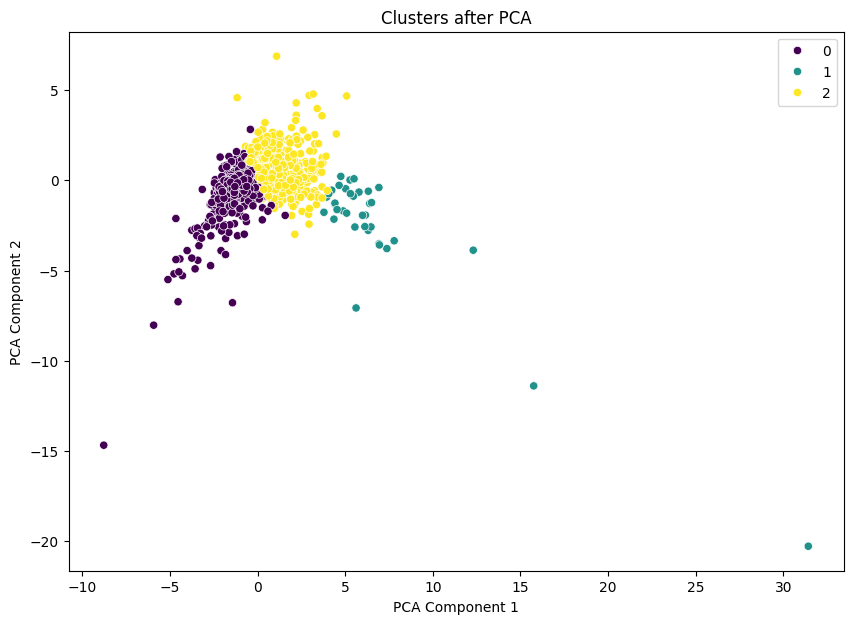

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_data)

cleaned_data['Cluster'] = clusters

if pca_data.shape[1] >= 2:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis')
    plt.title("Clusters after PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

In [6]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print("Cluster Centroids (in PCA space):")
print(centroids)

Cluster Centroids (in PCA space):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.128006 -0.393147 -0.080478 -0.128275 -0.073748 -0.093749 -0.018752   
1  6.734938 -2.532604  0.297999 -0.413950 -0.629411 -0.080498 -0.002030   
2  0.975337  0.616595  0.079933  0.177801  0.124413  0.117357  0.022677   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.037326 -0.034798  0.254686 -0.039902 -0.105841  0.048610  0.017468   
1  0.101695 -0.189548 -0.100164 -0.122388 -0.346825  0.681259  0.015991   
2  0.039143  0.052613 -0.300746  0.054946  0.147005 -0.097108 -0.021923   

       PC15  
0  0.010061  
1 -0.112941  
2 -0.005702  


In [7]:
original_data_with_clusters = cleaned_data.copy()
original_data_with_clusters['Cluster'] = clusters

centroids_original_space = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
centroids_original_df = pd.DataFrame(centroids_original_space, columns=selected_columns)

risk_mapping = {
    0: "High Risk",
    1: "Medium Risk",
    2: "Low Risk"
}

original_data_with_clusters['Risk Level'] = original_data_with_clusters['Cluster'].map(risk_mapping)

high_risk_companies = original_data_with_clusters[original_data_with_clusters['Risk Level'] == "High Risk"]
medium_risk_companies = original_data_with_clusters[original_data_with_clusters['Risk Level'] == "Medium Risk"]
low_risk_companies = original_data_with_clusters[original_data_with_clusters['Risk Level'] == "Low Risk"]

print("High-Risk Companies:")
print(high_risk_companies)

print("\nMedium-Risk Companies:")
print(medium_risk_companies)

print("\nLow-Risk Companies:")
print(low_risk_companies)


High-Risk Companies:
       Z-SCORE  Asset liability ratio  Current ratio  Cash ratio  \
0     2.420039               0.648161       0.011240    0.394846   
9     3.250555               0.473534       0.018666    0.901602   
14    2.020820               0.564368       0.008871    0.358787   
20    2.768444               0.633090       0.011762    0.181972   
21    1.988926               0.727524       0.006666    0.171826   
...        ...                    ...            ...         ...   
1435  1.918700               0.430000       0.010000    0.300000   
1437  2.060600               0.650000       0.010000    0.300000   
1438  1.593100               0.580000       0.020000    0.000000   
1439  4.175800               0.450000       0.010000    0.570000   
1441  2.759900               0.850000       0.010000    0.080000   

      EBITDA/interest bearing debt       ROA       ROE  \
0                         0.501851  0.046191  0.129841   
9                         0.676477  0.127784  